In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.basemap import Basemap
import numpy as np
import matplotlib.patches as mpatches

In [10]:
# Set publication-quality style parameters
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['DejaVu Sans', 'Helvetica', 'Liberation Sans', 'Bitstream Vera Sans', 'sans-serif'],
    'font.size': 10,
    'axes.titlesize': 12,
    'axes.labelsize': 10,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'legend.fontsize': 9,
    'figure.dpi': 300,
    'savefig.dpi': 600
})

In [11]:
def load_and_clean_data(global_final_prediction_data, glohydrores_file, hybrid_model_file):
    global_final_prediction_data = pd.read_csv(global_final_prediction_data)
    global_final_prediction_data  = global_final_prediction_data.drop_duplicates(subset = "glohydrores_plant_id")
    global_final_prediction_data  = global_final_prediction_data[["glohydrores_plant_id", "plant_lat", "installed_capacity_mw"]]

    glohydrores_data = pd.read_excel(glohydrores_file, header=0, sheet_name="Data")
    global_final_prediction_data["plant_lon"] = global_final_prediction_data.glohydrores_plant_id.map(dict(zip(glohydrores_data.ID, glohydrores_data.plant_lon)))
    global_final_prediction_data["plant_type"] = global_final_prediction_data.glohydrores_plant_id.map(dict(zip(glohydrores_data.ID, glohydrores_data.plant_type)))

    global_final_prediction_data["plant_type"] = global_final_prediction_data.plant_type.fillna("NA")

    # Load and prepare generation data
    hybrid_model_data = pd.read_csv(hybrid_model_file,header=0)
    hybrid_model_data  = hybrid_model_data[["glohydrores_plant_id", "plant_lat", "installed_capacity_mw"]]

   
    number_of_months_each_plant = hybrid_model_data.groupby("glohydrores_plant_id").size()
    hybrid_model_data  = hybrid_model_data.drop_duplicates(subset = "glohydrores_plant_id")
    hybrid_model_data["months_data_avaialable"] = hybrid_model_data.glohydrores_plant_id.map(number_of_months_each_plant)

    hybrid_model_data["plant_lon"] = hybrid_model_data.glohydrores_plant_id.map(dict(zip(glohydrores_data.ID, glohydrores_data.plant_lon)))
    hybrid_model_data["plant_type"] = hybrid_model_data.glohydrores_plant_id.map(dict(zip(glohydrores_data.ID, glohydrores_data.plant_type)))

    hybrid_model_data["plant_type"] = hybrid_model_data.plant_type.fillna("NA")

    return global_final_prediction_data, hybrid_model_data


    

In [12]:
global_final_prediction_data, hybrid_model_data = load_and_clean_data(
    global_final_prediction_data = "/scratch/shah0012/hybrid_hydropower_model/hybrid_model_results/global_data_prediction_designed_dataset_1982_2022_target_CF.csv",
    glohydrores_file  = "/home/shah0012/GloHydroRes/Output_data/GloHydroRes_vs2.xlsx",
    hybrid_model_file = "/scratch/shah0012/hybrid_hydropower_model/data/hybrid_model_data/hybrid_model_train_generation_data_1981_2022_selected_variables_snow_cover_historical_plant_lat.csv"

)

### All Hydropwer Plants

/home/shah0012/.conda/envs/python_env/lib/python3.7/site-packages/ipykernel_launcher.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


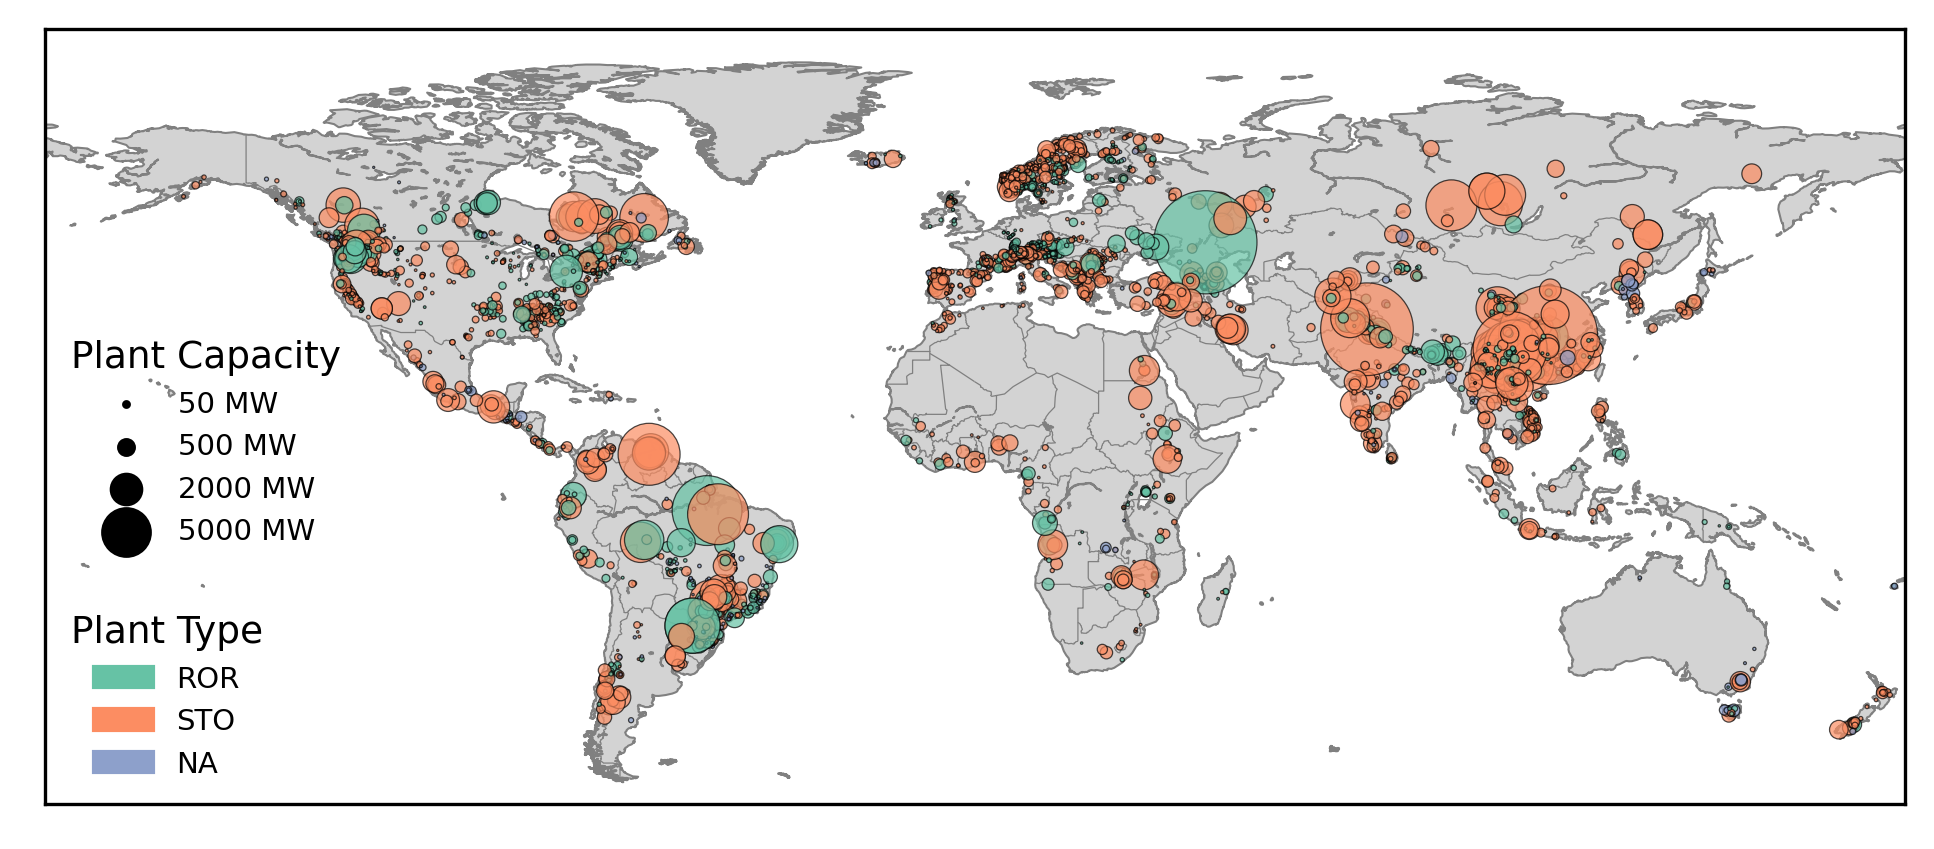

In [13]:
plant_lat = np.array(global_final_prediction_data.plant_lat)
plant_lon = np.array(global_final_prediction_data.plant_lon)
plant_capacity = np.array(global_final_prediction_data.installed_capacity_mw)

# Marker size will be proportional to plant capacity
marker_size = [cap * 0.025 for cap in plant_capacity]

global_final_prediction_data["plant_type_ordered"] = pd.Categorical(
    global_final_prediction_data["plant_type"], categories=['ROR', 'STO', 'NA'], ordered=True
)

levels = global_final_prediction_data["plant_type_ordered"].cat.codes
categories = global_final_prediction_data["plant_type_ordered"].cat.categories

colors = ["#66c2a5", "#fc8d62", "#8da0cb"]
full_colors = [colors[i] for i in levels]


# Create figure with GridSpec
fig = plt.figure(figsize=(8, 4), dpi=300)
gs = GridSpec(1, 1, hspace=0.3)

# First plot - All hydropower plants
ax1 = fig.add_subplot(gs[0])
m1 = Basemap(
    projection='cyl',
    llcrnrlat=-60,
    urcrnrlat=90,
    llcrnrlon=-180,
    urcrnrlon=180,
    resolution='l',
    ax=ax1
)
m1.drawcoastlines(linewidth=0.5, color='gray')
m1.fillcontinents(color="lightgrey", lake_color='white', zorder=1)
m1.drawcountries(linewidth=0.3, color='gray')

# Plot points
sc1 = ax1.scatter(
    plant_lon, plant_lat,
    s=marker_size,
    c=full_colors,
    zorder=5,
    alpha=0.7,
    edgecolors='black',
    linewidth=0.3
)

# Create legend for capacity (now first, positioned on top)
pws = pd.cut(plant_capacity, bins=[50, 500, 2000, 5000], retbins=True)[1].round(0)
capacity_handles = []
for pw in pws:
    capacity_handles.append(plt.scatter([], [], s=pw*0.025, c="k", label=f"{int(pw)}"))

legend2 = ax1.legend(
    handles=capacity_handles,
    labels=[f"{int(p)} MW" for p in pws],
    title="Plant Capacity",
    fontsize=7,
    loc="lower left",  # Changed to upper left
    bbox_to_anchor=(0, 0.30),
    frameon=False,
    title_fontsize=9
)
ax1.add_artist(legend2)  # Add this legend first

# Create legend for plant types (now second, positioned below)
plant_type_handles = [
    mpatches.Patch(color=colors[i], label=c)
    for i, c in enumerate(categories)
]
legend1 = ax1.legend(
    handles=plant_type_handles,
    title="Plant Type",
    frameon=False,
    fontsize= 7,
    loc="lower left",  # Keep at lower left
    title_fontsize=9
)

plt.tight_layout()
plt.savefig("/home/shah0012/Hydropower_hybrid_model/figures/all_hydropower_plant_location.pdf", format='pdf', dpi=600, bbox_inches='tight')
plt.show()

### Hydropower Plants with observed generation data

/home/shah0012/.conda/envs/python_env/lib/python3.7/site-packages/ipykernel_launcher.py:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


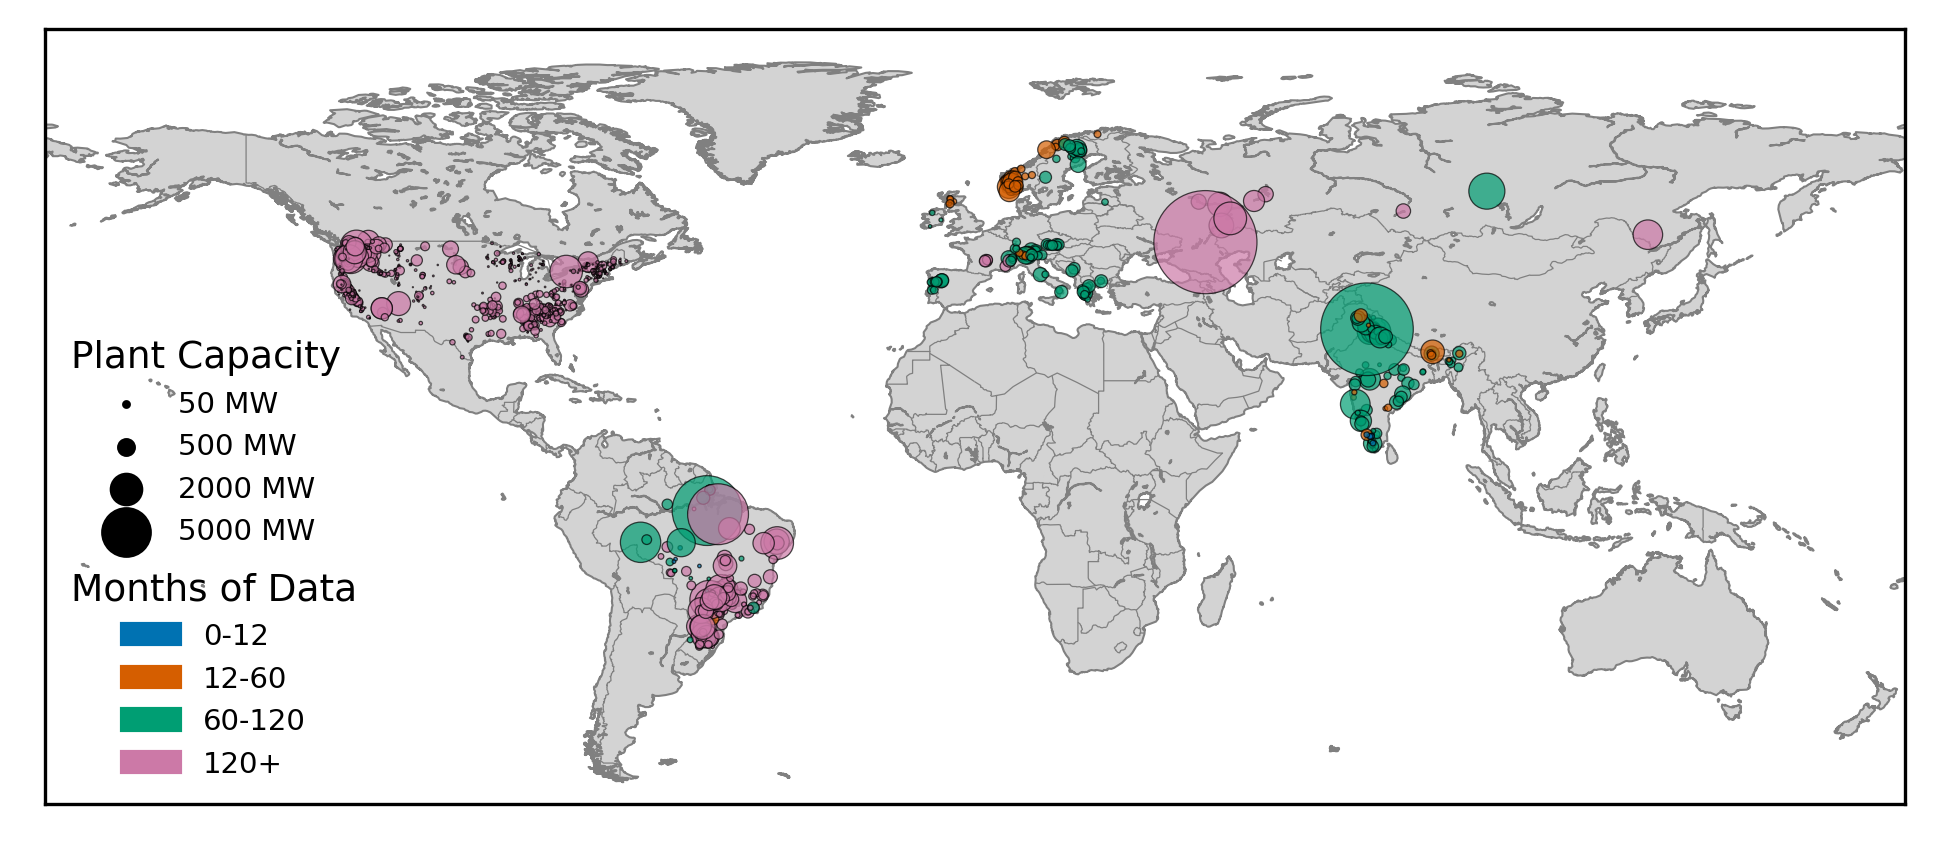

In [14]:
gen_plant_lat = np.array(hybrid_model_data.plant_lat)
gen_plant_lon = np.array(hybrid_model_data.plant_lon)
gen_plant_capacity = np.array(hybrid_model_data.installed_capacity_mw)

gen_marker_size = [cap * 0.025 for cap in gen_plant_capacity]

hybrid_model_data["cat_months_data_avaialable"] = pd.cut(
    hybrid_model_data.months_data_avaialable,
    bins=[0, 12, 60, 120, 240],
    labels=['0-12', '12-60', '60-120', '120+'],
    retbins=False
)
gen_levels = hybrid_model_data["cat_months_data_avaialable"].cat.codes
gen_categories = hybrid_model_data["cat_months_data_avaialable"].cat.categories

gen_colors = ["#0072B2", "#D55E00", "#009E73", "#CC79A7"]
gen_full_colors = [gen_colors[i] for i in gen_levels]

# Create figure with GridSpec
fig = plt.figure(figsize=(8, 4), dpi=300)
gs = GridSpec(1, 1, hspace=0.3)

# Second plot - Plants with generation data
ax2 = fig.add_subplot(gs[0])
m2 = Basemap(
    projection='cyl',
    llcrnrlat=-60,
    urcrnrlat=90,
    llcrnrlon=-180,
    urcrnrlon=180,
    resolution='l',
    ax=ax2
)
m2.drawcoastlines(linewidth=0.5, color='gray')
m2.fillcontinents(color="lightgrey", lake_color='white', zorder=1)
m2.drawcountries(linewidth=0.3, color='gray')

# Plot points
sc2 = ax2.scatter(
    gen_plant_lon, gen_plant_lat,
    s=gen_marker_size,
    c=gen_full_colors,
    zorder=5,
    alpha=0.7,
    edgecolors='black',
    linewidth=0.3
)

# Create legend for data availability
months_handles = [
    mpatches.Patch(color=gen_colors[i], label=c)
    for i, c in enumerate(gen_categories)
]
legend3 = ax2.legend(
    handles=months_handles,
    title="Months of Data",
    #framealpha=0.7,
    frameon = False,
    fontsize=7,
    loc="lower left",
    title_fontsize=9
)
ax2.add_artist(legend3)

# Create legend for capacity again
gen_pws = pd.cut(gen_plant_capacity, bins=[50, 500, 2000, 5000], retbins=True)[1].round(0)
gen_capacity_handles = []
for pw in gen_pws:
    gen_capacity_handles.append(plt.scatter([], [], s=pw*0.025, c="k", label=f"{int(pw)}"))

legend4 = ax2.legend(
    handles=gen_capacity_handles,
    labels=[f"{int(p)} MW" for p in gen_pws],
    title="Plant Capacity",
    fontsize=7,
    loc="lower left",
    bbox_to_anchor=(0, 0.30),
    #framealpha=0.7,
    frameon = False,
    title_fontsize=9
)


plt.tight_layout()


# Save the figure
plt.savefig("/home/shah0012/Hydropower_hybrid_model/figures/observed_plant_location.pdf", format='pdf', dpi=600, bbox_inches='tight')
plt.show()